# Connected Car Challenge

This notebook deals with the analysis of the data desigbed for the _Connected Car Challenge_. You can obtain the data from [here].

We first import the neccessary packages:

In [281]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math

sns.set(color_codes=True)

Then we read the whole data :

In [2]:
dt = pd.read_csv ("candump-2017-06-20_022638" , sep = " " , names = ['a' , 'b' , 'c'])

In [4]:
dt.head()

,a,b,c
0,(1497925598.604522),can0,233#2F0FFF0C00D10100
1,(1497925598.604710),can0,223#890513004A000081
2,(1497925598.606356),can0,00E#20E3200004FF40E2
3,(1497925598.606391),can0,228#40C040A1
4,(1497925598.608609),can0,408#20


In [236]:
len(dt)

15833917

As you can see the data is not meaningful yet. We have to clean it and convert it to a readable ones. Here how we did it here :

In [237]:
dt2 = dt.iloc[:,:]
data = dt2.copy()

data['id']     =  data['c'].apply(lambda s : s[:3])
data['time']   =  data['a'].apply(lambda s : (float (s[1:-1]) - 1497925598.604522))
data['value'] =  data['c'].apply(lambda s : int (s[4:],16))

data.drop(['a', 'b' , 'c'], axis=1 , inplace = True)
data.head()

,id,time,value
0,233,0.000000,3391209471451660544
1,223,0.000188,9873318650042122369
2,00E,0.001834,2369773013382938850
3,228,0.001869,1086341281
4,408,0.004087,32


The `id` column corresponds to the ids of the sensors the examinator and we have to seperate the data into different groups by the help of their ids. Then we habe to drop the ids that have no information in their values. We dropped the ones that are (alsmot) constant.

In [238]:
ids = np.unique( data.id )
print ("The number of uniques in ids are " + str (len(ids)) )

grouped = data.groupby (['id'])
idsStd = grouped ['value'].std()
badids = idsStd [idsStd < 0.01].index

badindex = list(grouped.get_group(badids[0]).index)
for i in range (len(badids)-1):
    badindex = badindex + list(grouped.get_group(badids[i+1]).index)
    
dataCleaned    = data.drop(badindex)
grouped = dataCleaned.groupby (['id'])


The number of uniques in ids are 268


As you can see below, quite half of the sensors do not provide us an information.

In [241]:
len(dataCleaned) , len(data) , len(ids) , len(badids)

(14895639, 15833917, 268, 105)

We will plot in next part the corresponding evolution of signal for each of the sensors. There are a few things we have to notice here:

1. The signals do not start at the same time. Some of them are registered from time 0 while there are the ones which start at the 350 second (in 10 minutes).

2. Some of the signals are just a slight shift (in time) of each other.

3. There are a very highly oscilating signals. We should put a low-pass filter to take a better picture about their evolution.

In [248]:
goodids = np.unique( dataCleaned.id )
goodids

array(['00E', '102', '106', '108', '115', '116', '126', '136', '138',
       '145', '148', '154', '155', '178', '185', '1A5', '1D4', '1F8',
       '202', '204', '206', '207', '209', '20A', '20B', '20C', '20E',
       '210', '212', '217', '218', '219', '21A', '21B', '21C', '222',
       '223', '227', '228', '229', '22B', '22C', '232', '233', '236',
       '237', '238', '239', '23A', '23B', '23C', '23E', '246', '247',
       '248', '249', '24A', '24B', '24C', '24E', '256', '258', '25A',
       '25C', '266', '267', '268', '26A', '278', '27A', '286', '28A',
       '29A', '2AA', '2BF', '2C8', '2D5', '2E5', '302', '305', '306',
       '308', '30A', '312', '314', '318', '31A', '328', '32A', '332',
       '338', '33A', '344', '356', '358', '35A', '366', '36A', '378',
       '37A', '382', '385', '388', '38A', '391', '39A', '3A8', '3AA',
       '3B8', '3BA', '3BF', '3C8', '3CA', '3D2', '3D8', '3DA', '3E8',
       '3F2', '3F8', '408', '412', '418', '428', '45C', '4BA', '508',
       '50A', '51A',

We noticed that the starting time of the different sensors are different as you see below: 

In [306]:
grouped['time'].min()

id
00E       0.001834
102       0.005467
106     354.451217
108     354.387590
115     354.416851
116     354.452628
126     354.543845
136     354.452748
138     354.469598
145     354.416990
148     354.387608
154     354.400848
155     354.416960
178     354.377355
185     354.387620
1A5     354.508106
1D4     354.371872
1F8     354.387849
202       0.060564
204     354.440622
206     354.452845
207       0.031941
209       0.031557
20A       0.031655
20B       0.025962
20C       0.038581
20E       0.016937
210       0.094939
212       0.060690
217       0.041158
          ...     
539       0.732319
53A       0.024322
53B       0.826185
53C       0.738924
53E       5.217009
547       0.038957
549       0.039072
54B       0.039212
556     355.445212
562       9.434863
5B8       0.093556
5D2       0.426554
5D5     355.409587
5D8       1.774410
5E8       0.133684
620    2397.649052
62A       0.881903
63A    2397.413035
655     355.408982
656     355.444087
65A       0.719820
65D     3

In [277]:
mins = grouped['time'].min()
indexGroup1 = mins[mins<300].index
indexGroup2 = mins[np.logical_and(mins>300 , mins<2300)].index
indexGroup3 = mins[mins>2300].index

Index(['50A', '620', '63A'], dtype='object', name='id')

In [304]:
impIds = ['00E', '102', '106', '108', '115', '116', '126', '136', '138',
       '145', '148', '154', '155', '178', '185', '1A5', '1D4', '1F8',
       '202', '204', '206', '207', '209', '20A', '20B', '20C', '20E',
       '210', '212', '217', '218', '219', '21A', '21B', '21C', '222',
       '223', '227', '228', '229', '22B', '22C', '232', '233', '236',
       '237', '238', '239', '23A', '23B', '23C', '23E', '246', '247',
       '248', '249', '24A', '24B', '24C', '24E', '256', '258', '25A',
       '25C', '266', '267', '268', '26A', '278', '27A', '286', '28A',
       '29A', '2AA', '2BF', '2C8', '2D5', '2E5', '302', '305', '306',
       '308', '30A', '312', '314', '318', '31A', '328', '32A', '332',
       '338', '33A', '344', '356', '358', '35A', '366', '36A', '378',
       '37A', '382', '385', '388', '38A', '391', '39A', '3A8', '3AA',
       '3B8', '3BA', '3BF', '3C8', '3CA', '3D2', '3D8', '3DA', '3E8',
       '3F2', '3F8', '408', '412', '418', '428', '45C', '4BA', '508',
       '50A', '51A', '51E', '524', '526', '528', '537', '539', '53A',
       '53B', '53C', '53E', '547', '549', '54B', '556', '562', '5B8',
       '5D2', '5D5', '5D8', '5E8', '620', '62A', '63A', '655', '656',
       '65A', '65D', '6D4', '6F2', '717', '719', '71B', '71E', '76C',
       '7E2']

def PlottingByIndexGroup (indexGroup):
    ncols=1
    nrows = int(np.ceil(len(indexGroup) /ncols))

    #fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,100*ncols))
    #for (key, ax) in zip(impIds , axes.flatten()):
    #    x , y = grouped.get_group(key)['time'] , grouped.get_group(key)['value']
    #    ax.plot (np.array(x) , np.array(y))
    #    ax.set_title(key)

    fig, ax = plt.subplots(1, 1, figsize=(20,100*ncols))
    for (isignal, key) in enumerate(indexGroup):
        x , y = grouped.get_group(key)['time'] , grouped.get_group(key)['value']
        ax.plot (np.array(x) , (np.array(y) - y.min())/1.1/(y.max()-y.min() + 1e-30) + isignal, c='black')
    ax.set(yticks=list(range(nrows)), yticklabels=impIds, xlabel='time [s]', ylabel='sensor id', ylim=(-0.5, nrows+0.5));


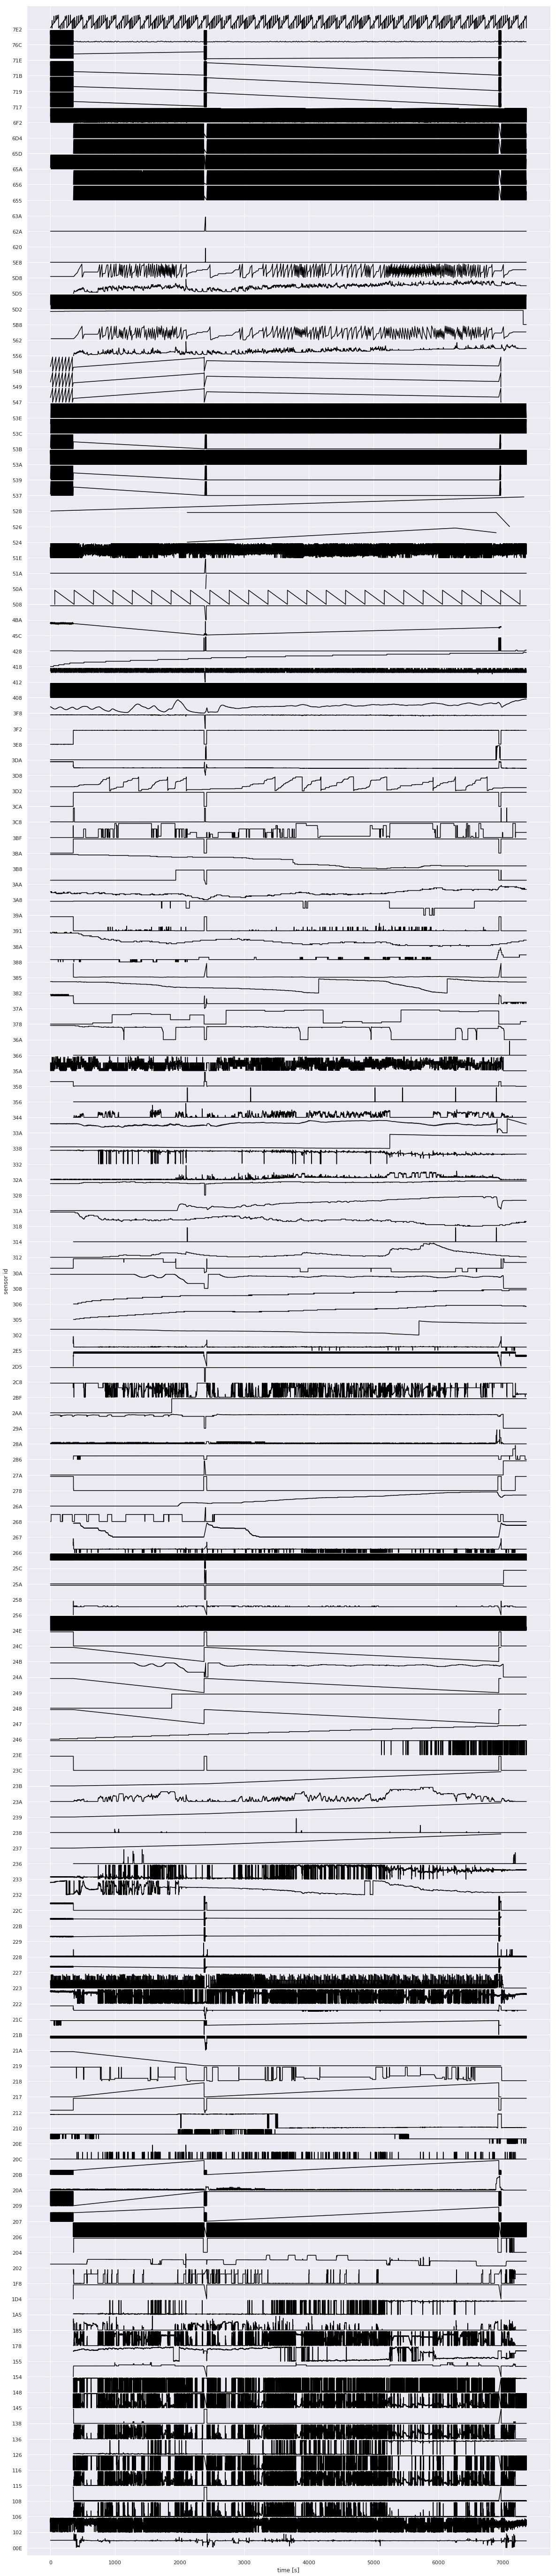

In [305]:
PlottingByIndexGroup (impIds)
plt.savefig('totalPlotting.png')

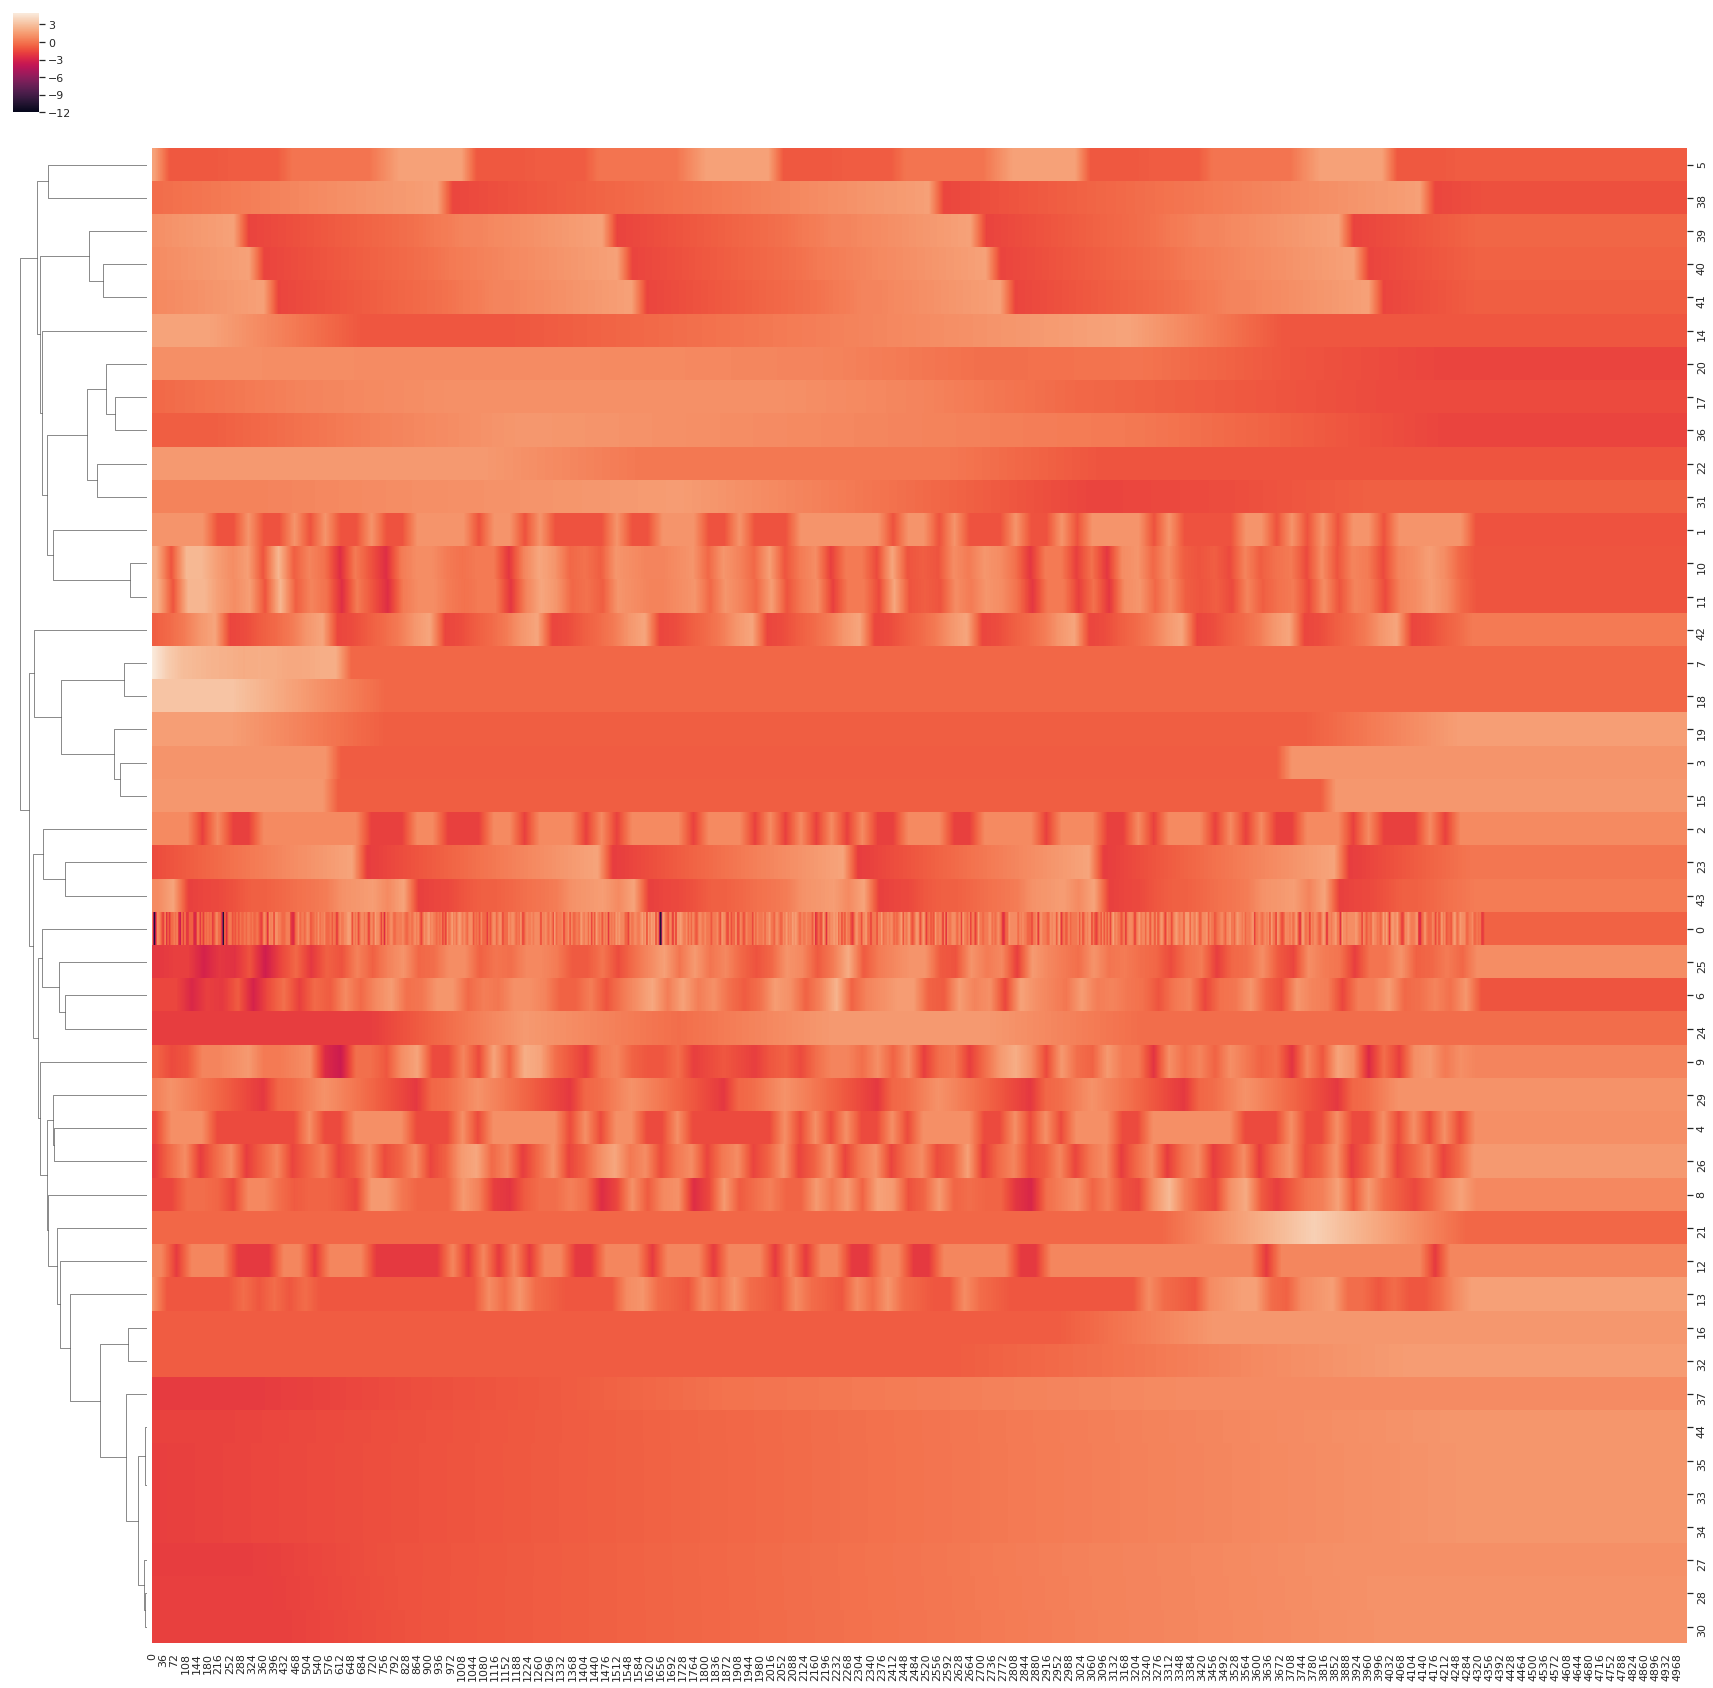

In [148]:
nsignals = len(indexGroup1)
new_times = np.linspace(0, 10, 5000)

signals = np.empty((nsignals, 5000))
for isignal, signal in enumerate(mdict.values()):
    signals[isignal] = np.interp(new_times, signal[:, 0], signal[:, 1])
    
signals = (signals - signals.mean(axis=1)[:, None])/(signals.std(axis=1)[:, None]  + 1e-10)
# plt.figure(figsize=(20, 20))
# plt.imshow(signals, aspect='auto')

import seaborn as sns; sns.set(color_codes=True)
g = sns.clustermap(signals, col_cluster=False, figsize=(30, 30))

plt.savefig('clustering.jpg')